In [1]:
import os

import pandas as pd

import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense , GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2

In [2]:
import tensorflow as tf
print(tf.__version__)

2.15.0


**Creating the Dataframe**

In [3]:
root_dir='./archive/train/'

categories=os.listdir(root_dir)

filepaths=[]
labels=[]

for category in categories:
    category_path=os.path.join(root_dir,category)
    if os.path.isdir(category_path):
        for fname in os.listdir(category_path):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                filepaths.append(os.path.join(category_path, fname))
                labels.append(category)


#Creating the Dataframe
df=pd.DataFrame({'filepath': filepaths , 'label' : labels})

#shufleing the Datframe
df=df.sample(frac=1).reset_index(drop=True)

df.head()


,filepath,label
0,./archive/train/dandelion\18587334446_ef102190...,dandelion
1,./archive/train/rose\3268459296_a7346c6b2c.jpg,rose
2,./archive/train/tulip\13911047024_8966d70560_n...,tulip
3,./archive/train/sunflower\5032376020_2ed312306...,sunflower
4,./archive/train/dandelion\19064700925_b93d474e...,dandelion


**Image DataGenerator**

In [4]:
IMG_SIZE=224
BATCH_SIZE=32

datagen=ImageDataGenerator(rescale=1./255,validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    subset='training',
    batch_size=BATCH_SIZE,
    shuffle=True
)


val_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    subset='validation',
    batch_size=BATCH_SIZE,
    shuffle=True
)


Found 2197 validated image filenames belonging to 5 classes.
Found 549 validated image filenames belonging to 5 classes.


**Building the CNN with MobileNetV2**

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

IMG_SIZE = 224  # replace with your actual IMG_SIZE

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Block 1
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2))(x)

# Block 2
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

# Block 3
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

# Block 4
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

# Global Average Pooling and Fully Connected layers
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)

predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       7385

**Training the model**

In [6]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


Epoch 1/10


69/69 [==============================] - 62s 887ms/step - loss: 1.4449 - accuracy: 0.3341 - val_loss: 1.2574 - val_accuracy: 0.4936
Epoch 2/10
69/69 [==============================] - 43s 622ms/step - loss: 1.2195 - accuracy: 0.4661 - val_loss: 1.1497 - val_accuracy: 0.4954
Epoch 3/10
69/69 [==============================] - 44s 645ms/step - loss: 1.1302 - accuracy: 0.4989 - val_loss: 1.0997 - val_accuracy: 0.5428
Epoch 4/10
69/69 [==============================] - 49s 704ms/step - loss: 1.0751 - accuracy: 0.5462 - val_loss: 1.0257 - val_accuracy: 0.5683
Epoch 5/10
69/69 [==============================] - 47s 677ms/step - loss: 1.0146 - accuracy: 0.5881 - val_loss: 0.9834 - val_accuracy: 0.6047
Epoch 6/10
69/69 [==============================] - 54s 786ms/step - loss: 0.9749 - accuracy: 0.5995 - val_loss: 0.9419 - val_accuracy: 0.6102
Epoch 7/10
69/69 [==============================] - 65s 927ms/step - loss: 0.9046 - accuracy: 0.6427 - val_loss: 0.9393 - val_accuracy: 0.62

**Evaluate Performance**

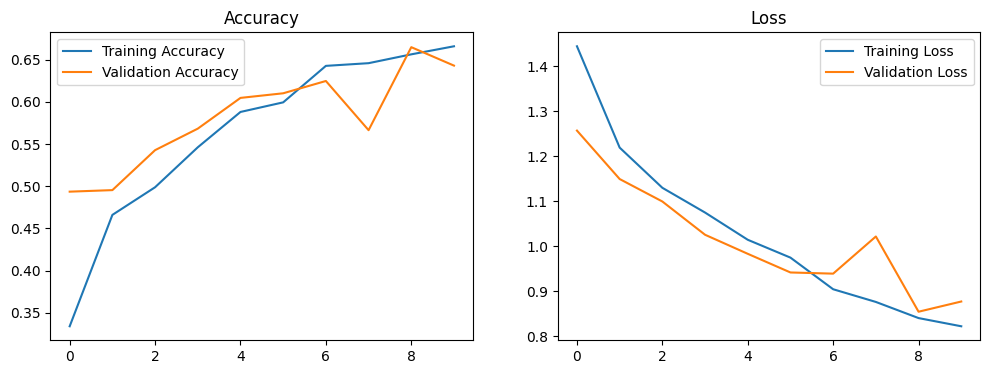

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title("Loss")

plt.show()


**Fine-tune the model**